In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq, minimize
from scipy.integrate import quad
from joblib import Parallel, delayed

1. Calibration

In [2]:
#Outils necéssaires pour la suite

def bs(F, K, V, o = 'call'):
    """
    Prix du call B&S à partir de la vol
    """

    w = 1
    if o == 'put':
        w = -1
    elif o == 'otm':
        w = 2 * (K > 1.0) - 1

    sv = np.sqrt(V)
    d1 = np.log(F/K) / sv + 0.5 * sv
    d2 = d1 - sv
    P = w * F * norm.cdf(w * d1) - w * K * norm.cdf(w * d2)
    return P

def bsinv(P, F, K, t, o = 'call'):
    """
    vol implicite à partir du prix B&S
    """

    w = 1
    if o == 'put':
        w = -1
    elif o == 'otm':
        w = 2 * (K > 1.0) - 1

    # Valeur intrinsèque
    P = np.maximum(P, np.maximum(w * (F - K), 0))

    def error(s):
        return bs(F, K, s**2 * t, o) - P
    s = brentq(error, 1e-9, 10)         #Newton pour aller plus vite ? et a et b bien choisi ? à voir
    return s


In [3]:
#Solution fermée du modèle de heston : solution analytique du Prix du Call (Put)

def heston_cf(u, S0, v0, kappa, theta, sigma, rho, tau, r):
    a = kappa * theta
    d = np.sqrt((rho * sigma * 1j*u - kappa)**2 + sigma**2 * (1j*u + u**2))
    g = (kappa - rho * sigma * 1j*u - d) / (kappa - rho * sigma * 1j*u + d)
    C = r * 1j*u*tau + (a / sigma**2) * ((kappa - rho*sigma*1j*u - d)*tau- 2*np.log((1 - g*np.exp(-d*tau))/(1 - g)))
    D = ((kappa - rho*sigma*1j*u - d)/sigma**2) * ((1 - np.exp(-d*tau)) / (1 - g*np.exp(-d*tau)))
    return np.exp(C + D*v0 + 1j*u*np.log(S0))

def integrand(phi, S0, K, v0, kappa, theta, sigma, rho, tau, r, alpha):
    u = phi - 1j*(alpha+1)
    cf_val = heston_cf(u, S0, v0, kappa, theta, sigma, rho, tau, r)
    num = np.exp(-r*tau) * cf_val
    den = alpha**2 + alpha - phi**2 + 1j*(2*alpha+1)*phi
    return (np.exp(-1j * phi * np.log(K)) * num / den).real

def call_price_heston(S0, K, v0, kappa, theta, sigma, rho, tau, r, alpha=1.5, phi_max=50):
    integrand_func = lambda phi: integrand(phi, S0, K, v0, kappa, theta,sigma, rho, tau, r, alpha)
    integral, _ = quad(integrand_func, 1e-6, phi_max, limit=100, epsabs=1e-4, epsrel=1e-4)
    return np.exp(-alpha*np.log(K)) / np.pi * integral


In [4]:
#Notre fonction error entre le modèle et les données

def error_row(row, params, r, alpha, phi_max):
    """
    Calcule l'erreur au carré entre la vol modèle (Heston + Carr-Madan + bsinv)
    et la vol de marché (extrait de la SVI).
    """
    v0, kappa, theta, sigma, rho = params

    F   = row['Forward']    # Forward pour cette maturité
    tau = row['Tau']        # Maturité en années
    K   = row['Strike']     # Strike
    market_vol = row['VolImp']  # Vol implicite de marché ( en décimal!)

    # Prix modèle Heston + Vol implicite modèle
    model_price = call_price_heston(F, K, v0, kappa, theta, sigma, rho, tau, r, alpha, phi_max)
    model_vol = bsinv(model_price, F, K, tau, o='call')

    if np.isnan(model_vol):
        return None

    return (model_vol - market_vol)**2


In [5]:
#Définition de notre objectif : on calcule l'erreur pour chaque ligne de notre slice

def objective_parallel(params, df_slice, r, alpha=1.5, phi_max=50, n_jobs=-1):
    """
    Fonction objectif
    moyenne des erreurs au carré sur toutes les options de df_slice.
    """
    errors = []

    for _, row in df_slice.iterrows():
        e = error_row(row, params, r, alpha, phi_max)
        if e is not None:
            errors.append(e)

    if len(errors) == 0:
        return np.inf

    return sum(errors) / len(errors)

def objective_wrapper(params, df_slice, r, alpha=1.5, phi_max=50):

    val = objective_parallel(params, df_slice, r, alpha, phi_max, n_jobs=-1)
    print(f"Parameters: {params}, Objective: {val:.6f}")
    return val

In [6]:
#Création du Dataset

df = pd.read_excel("/content/SURF_.SPX_20251211141104.xlsx") #Surface : maturité en lignes et strike en colonnes

df['Tau'] = df['Exp'].str.replace('M', '', regex=False).astype(int) / 12.0  #On récupère nos maturités pour itérés sur toutes nos slices

non_strike_cols = ['Exp', 'Date', 'Forward', 'Tau']
strike_cols = [c for c in df.columns if c not in non_strike_cols]

final_df = df.melt(
    id_vars=['Exp', 'Tau', 'Forward'],
    value_vars=strike_cols,
    var_name='Strike',
    value_name='VolImp'
)

final_df['Strike'] = pd.to_numeric(final_df['Strike'], errors='coerce')
final_df = final_df.dropna(subset=['Strike'])  # au cas où il reste une colonne non numérique

final_df['VolImp'] = final_df['VolImp'] / 100.0

final_df = final_df.sort_values(['Tau', 'Strike']).reset_index(drop=True)

print(final_df.head())
final_df.to_excel("flattened_surface.xlsx", index=False)


  Exp       Tau   Forward   Strike   VolImp
0  1M  0.083333  6864.507  3443.34  0.57307
1  1M  0.083333  6864.507  4132.01  0.49347
2  1M  0.083333  6864.507  4820.68  0.41451
3  1M  0.083333  6864.507  5165.01  0.37389
4  1M  0.083333  6864.507  5509.34  0.33154


In [7]:
#On lance la calibration

initial_params = [0.06, 2.0, 0.04, 0.6, -0.7] #Les paramètres initiaux doivent être assez proche de ce qu'on attends
bounds = [(0.001, 1), (0.001, 10), (0.001, 1), (0.001, 2), (-0.999, 0)] #bornes dans l'espace attendu de nos paramètres (peuvret être resséré ou élagri)

r = 0.01975  # taux fixe

unique_T = sorted(final_df['Tau'].unique())
results = []

for T_i in unique_T:
    df_i = final_df[final_df['Tau'] == T_i].copy()

    print(f"\n=== Calibration pour T = {T_i:.3f} ans ===")

#Calibration de la tranche i
    res = minimize(
        objective_wrapper,
        initial_params,
        args=(df_i, r, 1.5, 50),
        bounds=bounds,
        method='L-BFGS-B'
    )

    print("Paramètres calibrés (v0, kappa, theta, sigma, rho) :", res.x)
    print("Erreur objective :", res.fun)


#On stock nos paramètres a chaque lignes pour avoir un tableau a la fin
    results.append({
        "T": T_i,
        "v0": res.x[0],
        "kappa": res.x[1],
        "theta": res.x[2],
        "sigma": res.x[3],
        "rho": res.x[4],
        "error": res.fun,
    })

params_surface = pd.DataFrame(results)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Parameters: [ 1.00000000e-03  2.00259944e+00  1.30242556e-01  5.58064772e-01
 -6.51919986e-01], Objective: 0.005443
Parameters: [ 1.00000000e-03  2.00259943e+00  1.30242566e-01  5.58064772e-01
 -6.51919986e-01], Objective: 0.005443
Parameters: [ 1.00000000e-03  2.00259943e+00  1.30242556e-01  5.58064782e-01
 -6.51919986e-01], Objective: 0.005443
Parameters: [ 1.00000000e-03  2.00259943e+00  1.30242556e-01  5.58064772e-01
 -6.51919976e-01], Objective: 0.005443
Parameters: [ 1.00000000e-03  2.00260984e+00  1.30114833e-01  5.57681272e-01
 -6.51658189e-01], Objective: 0.005443
Parameters: [ 1.00001000e-03  2.00260984e+00  1.30114833e-01  5.57681272e-01
 -6.51658189e-01], Objective: 0.005443
Parameters: [ 1.00000000e-03  2.00260985e+00  1.30114833e-01  5.57681272e-01
 -6.51658189e-01], Objective: 0.005443
Parameters: [ 1.00000000e-03  2.00260984e+00  1.30114843e-01  5.57681272e-01
 -6.51658189e-01], Objective: 0.0

In [8]:
#On sort le dataframe contenant nos paramètres pour chaque maturité

params_surface

,T,v0,kappa,theta,sigma,rho,error
0,0.083333,0.021566,1.999663,0.048208,0.576559,-0.574836,0.026222
1,0.166667,0.017189,1.980440,0.047796,0.323330,-0.267415,0.009194
2,0.250000,0.001108,2.018130,0.066199,0.026035,-0.270438,0.004952
3,0.333333,0.001619,2.015444,0.073901,0.211091,-0.561460,0.002427
4,0.416667,0.001562,2.014043,0.063649,0.346104,-0.622714,0.001598
5,0.500000,0.033804,2.017515,0.001000,0.284470,-0.607262,0.001271
6,0.583333,0.001000,2.014181,0.051868,0.326508,-0.607416,0.001043
7,0.666667,0.001256,2.023679,0.048062,0.291794,-0.666566,0.000852
8,0.750000,0.042883,2.034356,0.001000,0.198885,-0.652931,0.000736
9,0.833333,0.001000,2.022333,0.042524,0.245945,-0.705736,0.000672


2. Test sur le modèle et Pricing par méthode numérique

In [9]:
#La classe pour la simulation de monte-carlo du modèle de Heston

class heston():
  def __init__(self, n, N, T):

        self.T = T
        self.n = n
        self.dt = T/n
        self.s = self.n
        self.t = np.linspace(0, self.T, 1 + self.s)[np.newaxis,:]
        self.N = N

  def dW1(self):
    Z1 = np.random.randn(self.N, self.n)
    return Z1* np.sqrt(self.dt)

  def dW2(self, dW1, rho):
    self.rho = rho
    Z2 = np.random.randn(self.N,self.n)
    return rho * dW1 + np.sqrt(1-rho**2) * Z2 * np.sqrt(self.dt)    #Correl

  def V(self, dW2, theta, kappa, sigma, V0):
    V =np.zeros((self.N, self.n +1))
    self.V0 = V0
    V[:,0]=self.V0
    self.theta = theta
    self.kappa = kappa
    self.sigma = sigma
    for i in range(1,self.n+1):
      V[:,i]= V[:,i-1] + kappa*(theta - V[:,i-1]) * self.dt + sigma * np.sqrt(np.maximum(V[:,i-1], 0.0)) * dW2[:,i-1] #max est une sécu au cas ou
    return V

  def S(self, V, r, S0, dW1):
    S = np.zeros((self.N, self.n+1))
    self.S0 = S0
    S[:,0] = self.S0
    self.r = r
    for i in range(1, self.n +1):
      S[:, i] = S[:, i-1] * np.exp((r - 0.5 * np.maximum(V[:,i-1], 0.0)) * self.dt
                                 + np.sqrt(np.maximum(V[:,i-1], 0.0)) * dW1[:, i-1])
    return S

In [10]:
n=252
N=10000
T=1   #Attention a bien faire correspondre la maturité avec les paramètres trouvés (ici 12 mois<=>dernière ligne du tableau)

model = heston(252, 10000, 1)

#paramètres
rho = -0.746303
theta = 0.038592
sigma = 0.201384
kappa = 2.016252
V0 = 0.001
S0 = 100
r = 0.027

#Mes browniens
dW1 = model.dW1()
dW2 = model.dW2(dW1, rho)

#Variance sto
V = model.V(dW2, theta, kappa, sigma, V0)

#Sous-Jacent
S = model.S(V, r, S0, dW1)

[0.01009031 0.01569111 0.01547722 ... 0.01280864 0.0160738  0.01064194]


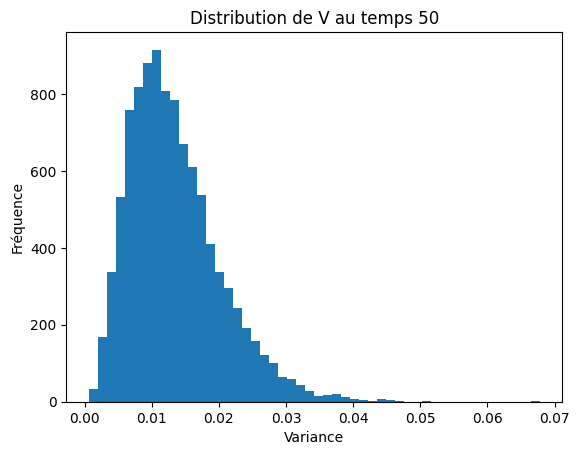

In [11]:
#Analyse de la distribution de nos volatilités

i = 50
vals_at_i = V[:, i]

print(vals_at_i)     # tu peux les afficher

plt.hist(V[:, i], bins=50)
plt.title(f"Distribution de V au temps {i}")
plt.xlabel("Variance")
plt.ylabel("Fréquence")
plt.show()



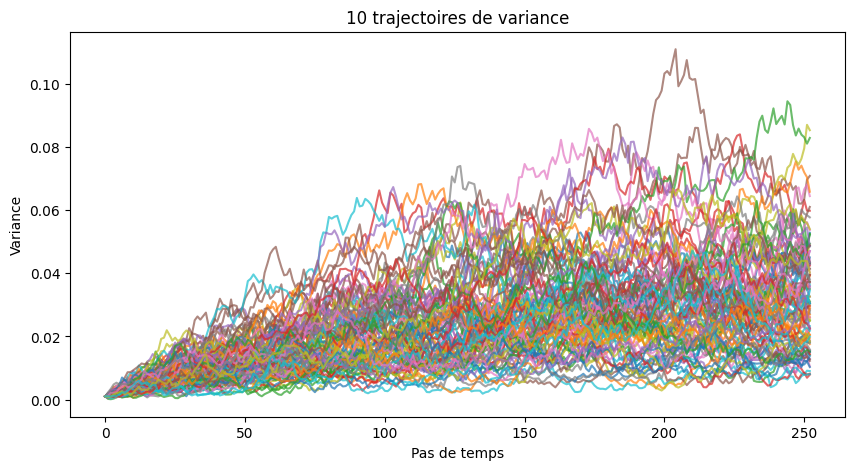

In [12]:
#Etude des trajectoires de variance

plt.figure(figsize=(10,5))

for k in range(100):
    plt.plot(V[k, :], alpha=0.7)

plt.title("10 trajectoires de variance")
plt.xlabel("Pas de temps")
plt.ylabel("Variance")
plt.show()


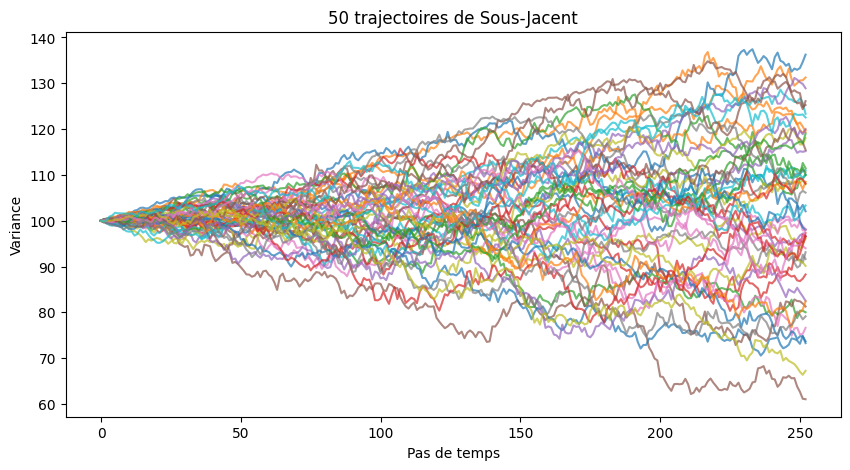

In [16]:
#Etude des Trajectoires du Sous-Jacent

plt.figure(figsize=(10,5))

for k in range(50):
    plt.plot(S[k, :], alpha=0.7)

plt.title("50 trajectoires de Sous-Jacent")
plt.xlabel("Pas de temps")
plt.ylabel("Variance")
plt.show()

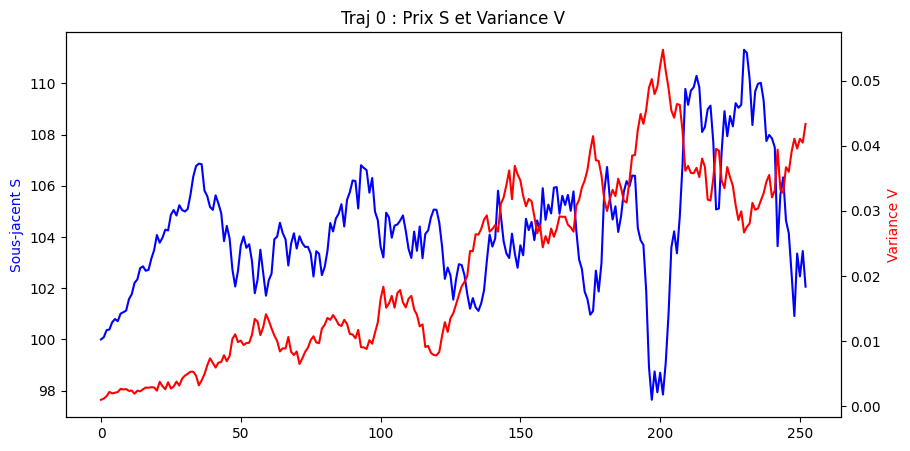

In [17]:
#Visualisation de la corrélation négative forte volatilité/spot (Skew)
#La corrélation négative et donc les phénomènes que les spikes de vol entrainant des chute brutales sont très bien modélisées par Heston

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(S[0, :], color="blue")
ax1.set_ylabel("Sous-jacent S", color="blue")

ax2 = ax1.twinx()
ax2.plot(V[0, :], color="red")
ax2.set_ylabel("Variance V", color="red")

plt.title("Traj 0 : Prix S et Variance V")
plt.show()

In [22]:
#prix du call ATM selon deux méthodes

#méthode itérative
a=0
K=100
for i in range (0,N):
  a+= np.maximum(S[i, n]-K, 0.0)
print((a/N)*np.exp(-r*T))

#méthode vectorisé
payoff = np.maximum(S[:,n]-K, 0.0)
print(np.mean(payoff)*np.exp(-r*T))

7.2817137936569525
7.281713793656939
